### Building our Hashtag Generator through NN and ALS recommendation 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from PIL import Image
import io
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel
from sklearn.model_selection import train_test_split
from functools import reduce
from func import prepare_image, extract_features
import os
from tqdm import tqdm
from scipy.spatial.distance import cosine
np.random.seed(0)

In [3]:
#Listing our key hashtags

json_file_names = os.listdir('metadata')
hashtags = [hashtag[:-5] for hashtag in json_file_names]

# remove '.DS_', '.ipynb_checkp'
non_hashtags = ['.DS_', '.ipynb_checkp']
for non_hashtag in non_hashtags:
    try:
        hashtags.remove(non_hashtag)
    except:
        pass # If we can't remove it, it's already gone
    
hashtags

['animals',
 'architecture',
 'babies',
 'cars',
 'coffee',
 'food',
 'nature',
 'selfie',
 'travel',
 'wedding']

In [4]:
# Combining the 10 key hashtags' metadata and making a DataFrame

hashtag_metadata = []
for hashtag in hashtags: 
    hashtag_metadata.append(pd.read_json(f'metadata/{hashtag}.json'))
hashtag_metadata = reduce(lambda x, y: pd.concat([x, y]), hashtag_metadata)
pd.DataFrame.reset_index(hashtag_metadata, drop=True, inplace=True)
hashtag_metadata.tail()

,post_link,image,search_hashtag,hashtags,image_local_name
75,https://www.instagram.com/p/CsS_3wxSsk_/,https://instagram.fccu1-2.fna.fbcdn.net/v/t51....,wedding,"[#ambani, #beautiful, #looking, #beautiful, #b...",cf13a19a-8f01-4b5f-9fac-4ad827517783.jpg
76,https://www.instagram.com/p/CsTN3kngxE4/,https://instagram.fccu1-2.fna.fbcdn.net/v/t51....,wedding,"[#weddingdecor, #wedding2023, #weddingphotogra...",43aa0f72-a6b4-4e9f-ad8f-51497fc458c0.jpg
77,https://www.instagram.com/p/CsSrQrPPyaC/,https://instagram.fccu1-2.fna.fbcdn.net/v/t51....,wedding,"[#prewedding, #wedding, #photography, #prewedd...",2b1be353-3fd3-4455-b722-505abbfa9998.jpg
78,https://www.instagram.com/p/CsSQz_WIcBi/,https://instagram.fccu1-2.fna.fbcdn.net/v/t51....,wedding,"[#photooftheday, #picoftheday, #post, #photo, ...",62c9940d-42be-4b05-a217-5117d5007e1d.jpg
79,https://www.instagram.com/p/CsRoU3qvCiA/,https://instagram.fccu1-2.fna.fbcdn.net/v/t51....,wedding,"[#sanrio, #studioghibli, #hellokitty, #kuromi,...",56c32f8c-a0d8-438d-8105-8cd51ed69862.jpg


In [5]:
hashtag_metadata['image']

0     https://instagram.fccu1-2.fna.fbcdn.net/v/t51....
1     https://instagram.fccu1-2.fna.fbcdn.net/v/t51....
2     https://instagram.fccu1-2.fna.fbcdn.net/v/t51....
3     https://instagram.fccu1-2.fna.fbcdn.net/v/t51....
4     https://instagram.fccu1-2.fna.fbcdn.net/v/t51....
                            ...                        
75    https://instagram.fccu1-2.fna.fbcdn.net/v/t51....
76    https://instagram.fccu1-2.fna.fbcdn.net/v/t51....
77    https://instagram.fccu1-2.fna.fbcdn.net/v/t51....
78    https://instagram.fccu1-2.fna.fbcdn.net/v/t51....
79    https://instagram.fccu1-2.fna.fbcdn.net/v/t51....
Name: image, Length: 80, dtype: object

In [6]:
#Data Cleaning 
hashtag_metadata['hashtags'] = hashtag_metadata['hashtags'].apply(
    lambda hashtag_list: [h for h in hashtag_list if h.startswith('#')])

all_hashtags = [hashtag for hashtags in hashtag_metadata['hashtags'] for hashtag in hashtags]

all_hashtags = sorted(list(set(all_hashtags)))

hashtag_lookup = {hashtag: i for i, hashtag in enumerate(all_hashtags)}

In [7]:
#Converting categorical data to numerical data

hashtag_rec_data = []
for i in hashtag_metadata.index:
    hashtag_list = hashtag_metadata.loc[i, 'hashtags']
    for hashtag in hashtag_list:
        hashtag_rec_data.append(
            {'image_id': i,
             'hashtag_id': hashtag_lookup[hashtag],
             'rating': 1}
        )
hashtag_rec_data = pd.DataFrame(hashtag_rec_data)
hashtag_rec_data.head()

,image_id,hashtag_id,rating
0,0,320,1
1,0,684,1
2,0,690,1
3,0,583,1
4,0,793,1


In [8]:
#Building our NN from here

img_shape = (160, 160, 3)

#Using the pre-trained model MobileNetV2 for our model
base_model = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

neural_network = tf.keras.Sequential([
  base_model,
  global_average_layer,
])

In [9]:
neural_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 2,257,984
Trainable params: 2,223,872
Non-trainable params: 34,112
_________________________________________________________________


In [10]:
#EagerTensor type to ensure powerful computation of a list of dictionaries representating a list of dictionaries

pics = []
for i, row in tqdm(hashtag_metadata.iterrows()):
    name = row['image_local_name']
    hashtag = row['search_hashtag']
    img_path = f'data/{hashtag}/{name}'
    try:
        img = prepare_image(img_path)
        deep_features = extract_features(img, neural_network)
        pics.append({'pic': img, 
                     'hashtag': hashtag, 
                     'name': name,
                     'deep_features': deep_features})
    except Exception as e:
        error_type = type(e).__name__
        if error_type == "NotFoundError":
            # If a file in the list isn't in 
            # storage, skip it and continue
            pass
        else:
            print(e)

0it [00:00, ?it/s]

1/1 [==============================] - 1s 663ms/step


1it [00:00,  1.32it/s]

1/1 [==============================] - 0s 33ms/step


3it [00:00,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


5it [00:01,  6.00it/s]

1/1 [==============================] - 0s 33ms/step


7it [00:01,  7.77it/s]

1/1 [==============================] - 0s 34ms/step


9it [00:01,  8.60it/s]

1/1 [==============================] - 0s 32ms/step


11it [00:01,  9.31it/s]

1/1 [==============================] - 0s 32ms/step


13it [00:01, 10.18it/s]

1/1 [==============================] - 0s 32ms/step


15it [00:01, 10.60it/s]

1/1 [==============================] - 0s 32ms/step


17it [00:02, 10.75it/s]

1/1 [==============================] - 0s 31ms/step


19it [00:02, 11.48it/s]

1/1 [==============================] - 0s 31ms/step


21it [00:02, 11.76it/s]

1/1 [==============================] - 0s 32ms/step


23it [00:02, 12.15it/s]

1/1 [==============================] - 0s 30ms/step


25it [00:02, 12.04it/s]

1/1 [==============================] - 0s 33ms/step


27it [00:02, 12.34it/s]

1/1 [==============================] - 0s 34ms/step


29it [00:03, 12.22it/s]

1/1 [==============================] - 0s 31ms/step


31it [00:03, 12.15it/s]

1/1 [==============================] - 0s 33ms/step


33it [00:03, 12.49it/s]

1/1 [==============================] - 0s 31ms/step


35it [00:03, 12.45it/s]

1/1 [==============================] - 0s 32ms/step


37it [00:03, 12.79it/s]

1/1 [==============================] - 0s 31ms/step


39it [00:03, 12.68it/s]

1/1 [==============================] - 0s 31ms/step


41it [00:04, 12.39it/s]

1/1 [==============================] - 0s 30ms/step


43it [00:04, 12.45it/s]

1/1 [==============================] - 0s 33ms/step


45it [00:04, 12.24it/s]

1/1 [==============================] - 0s 39ms/step


47it [00:04, 11.48it/s]

1/1 [==============================] - 0s 33ms/step


49it [00:04, 10.94it/s]

1/1 [==============================] - 0s 31ms/step


51it [00:04, 11.39it/s]

1/1 [==============================] - 0s 33ms/step


53it [00:05, 11.93it/s]

1/1 [==============================] - 0s 31ms/step


55it [00:05, 12.43it/s]

1/1 [==============================] - 0s 32ms/step


57it [00:05, 12.56it/s]

1/1 [==============================] - 0s 30ms/step


59it [00:05, 12.07it/s]

1/1 [==============================] - 0s 31ms/step


61it [00:05, 12.03it/s]

1/1 [==============================] - 0s 31ms/step


63it [00:05, 12.00it/s]

1/1 [==============================] - 0s 32ms/step


65it [00:06, 12.00it/s]

1/1 [==============================] - 0s 32ms/step


67it [00:06, 12.29it/s]

1/1 [==============================] - 0s 34ms/step


69it [00:06,  9.66it/s]

1/1 [==============================] - 0s 34ms/step


71it [00:06, 10.09it/s]

1/1 [==============================] - 0s 32ms/step


73it [00:06, 10.84it/s]

1/1 [==============================] - 0s 30ms/step


75it [00:07, 11.13it/s]

1/1 [==============================] - 0s 31ms/step


77it [00:07, 11.63it/s]

1/1 [==============================] - 0s 34ms/step


79it [00:07, 11.76it/s]

1/1 [==============================] - 0s 32ms/step


80it [00:07, 10.80it/s]


In [11]:
pics = pd.DataFrame(pics)
pics.index = pics['name']
pics.tail()

,pic,hashtag,name,deep_features
name,,,,
cf13a19a-8f01-4b5f-9fac-4ad827517783.jpg,"(((tf.Tensor(-0.71960783, shape=(), dtype=floa...",wedding,cf13a19a-8f01-4b5f-9fac-4ad827517783.jpg,"[0.0, 0.0, 0.1446628, 0.0026823045, 0.6367026,..."
43aa0f72-a6b4-4e9f-ad8f-51497fc458c0.jpg,"(((tf.Tensor(0.6392157, shape=(), dtype=float3...",wedding,43aa0f72-a6b4-4e9f-ad8f-51497fc458c0.jpg,"[0.005883074, 0.28074154, 0.0, 0.0, 0.2563188,..."
2b1be353-3fd3-4455-b722-505abbfa9998.jpg,"(((tf.Tensor(-0.672549, shape=(), dtype=float3...",wedding,2b1be353-3fd3-4455-b722-505abbfa9998.jpg,"[0.0, 0.6914874, 0.0020052718, 0.0035359382, 0..."
62c9940d-42be-4b05-a217-5117d5007e1d.jpg,"(((tf.Tensor(-0.99215686, shape=(), dtype=floa...",wedding,62c9940d-42be-4b05-a217-5117d5007e1d.jpg,"[0.24413465, 0.04146906, 2.4467802, 0.00826908..."
56c32f8c-a0d8-438d-8105-8cd51ed69862.jpg,"(((tf.Tensor(-0.99215686, shape=(), dtype=floa...",wedding,56c32f8c-a0d8-438d-8105-8cd51ed69862.jpg,"[0.0, 0.0, 0.0, 0.41944435, 0.74782914, 0.3170..."


In [12]:
pics.isna().sum()

pic              0
hashtag          0
name             0
deep_features    0
dtype: int64

In [13]:
#Cross checking a sample image from our data

pic = pics.iloc[60] 
type(pic['pic'])

tensorflow.python.framework.ops.EagerTensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('selfie', (1280,), TensorShape([160, 160, 3]))

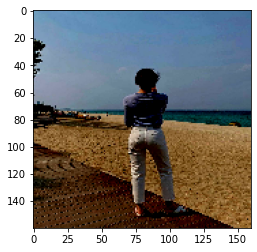

In [14]:
plt.imshow(pic['pic']);
pic['hashtag'], pic['deep_features'].shape, pic['pic'].shape

### ALS Recommendation System
#### ALS recommender is a matrix factorization algorithm that uses Alternating Least Squares with Weighted-Lamda-Regularization (ALS-WR), we use the same for collaborative filtering, such that, given a set of common hashtags and unique hashtags, it can generate relative hashtags for a new post.

In [15]:
spark = SparkSession.builder.master('local').getOrCreate()

In [16]:
#Fitting to ALS

als = ALS(userCol='image_id',
          itemCol='hashtag_id',
          implicitPrefs=True,
          alpha=40)

als.setSeed(0)
hashtag_spark_df = spark.createDataFrame(hashtag_rec_data)
als_model = als.fit(hashtag_spark_df)

In [17]:
hashtag_spark_df.show()

+--------+----------+------+
|image_id|hashtag_id|rating|
+--------+----------+------+
|       0|       320|     1|
|       0|       684|     1|
|       0|       690|     1|
|       0|       583|     1|
|       0|       793|     1|
|       0|       321|     1|
|       0|       318|     1|
|       0|       322|     1|
|       0|       345|     1|
|       0|       468|     1|
|       0|       476|     1|
|       0|        37|     1|
|       0|       135|     1|
|       0|       317|     1|
|       0|       982|     1|
|       0|       580|     1|
|       0|       687|     1|
|       0|        14|     1|
|       0|        13|     1|
|       0|        11|     1|
+--------+----------+------+
only showing top 20 rows



In [18]:
hashtag_rec_data = []
for i in hashtag_metadata.index:
    hashtag_list = hashtag_metadata.loc[i, 'hashtags']
    for hashtag in hashtag_list:
        hashtag_rec_data.append(
            {'image_id': i,
             'hashtag_id': hashtag_lookup[hashtag],
             'rating': 1}
        )
hashtag_rec_data = pd.DataFrame(hashtag_rec_data)
hashtag_rec_data.tail()

,image_id,hashtag_id,rating
1346,79,615,1
1347,79,712,1
1348,79,417,1
1349,79,945,1
1350,79,136,1


In [19]:
recs = als_model.recommendForAllUsers(numItems=10).toPandas()
recs.tail()

,image_id,recommendations
74,39,"[(478, 1.0228134393692017), (482, 0.9838891625..."
75,49,"[(579, 1.025179147720337), (380, 1.00483560562..."
76,69,"[(839, 0.9736930727958679), (897, 0.9731031060..."
77,29,"[(697, 0.9658389687538147), (206, 0.9585822820..."
78,79,"[(945, 0.9816802144050598), (615, 0.9349145889..."


In [20]:
hashtag_index = list(all_hashtags)
def lookup_hashtag(hashtag_id):
    return hashtag_index[hashtag_id]

def lookup_hashtag_recs(rec_scores):
    return [lookup_hashtag(rec) for (rec, score) in rec_scores]

In [21]:
recs['recommended_hashtags'] = recs['recommendations'].apply(lookup_hashtag_recs)
recs.index = recs['image_id']
recs = recs.join(hashtag_metadata, how='left')[['recommendations',
                                                 'recommended_hashtags',
                                                 'hashtags',
                                                 'image_local_name',
                                                 'search_hashtag']]

In [22]:
recs.drop('recommendations', axis=1, inplace=True)
image_factors = als_model.userFactors.toPandas()
image_factors.index = image_factors['id']
recs.join(image_factors);

In [23]:
# Add deep features information to recs dataframe
recs_deep = recs.join(pics, on='image_local_name', how='inner')
recs_deep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 20 to 79
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   recommended_hashtags  79 non-null     object
 1   hashtags              79 non-null     object
 2   image_local_name      79 non-null     object
 3   search_hashtag        79 non-null     object
 4   pic                   79 non-null     object
 5   hashtag               79 non-null     object
 6   name                  79 non-null     object
 7   deep_features         79 non-null     object
dtypes: object(8)
memory usage: 5.6+ KB


In [24]:
len(hashtag_lookup), type(hashtag_lookup)

(994, dict)

In [25]:
hashtags_df = pd.DataFrame.from_dict(hashtag_lookup, orient='index')
hashtags_df.head()

,0
#90sfashion,0
#Classic,1
#Classiccar,2
#Musclecar,3
#Musclecars,4


In [26]:
hashtags_df = hashtags_df.reset_index()
hashtags_df.columns = ['hashtag', 'id']
hashtags_df.index = hashtags_df['id']
hashtags_df.drop('id', axis=1, inplace=True)
hashtags_df.head()

,hashtag
id,
0,#90sfashion
1,#Classic
2,#Classiccar
3,#Musclecar
4,#Musclecars


In [27]:
img_features = als_model.userFactors.toPandas()
hashtag_features = als_model.itemFactors.toPandas()

In [28]:
recs_deep_clean = recs_deep[['image_local_name', 'hashtags', 'deep_features']]

img_features.index = img_features['id']
img_features.drop(['id'], axis=1)

recommender_df = recs_deep_clean.join(img_features, how='inner')
recommender_df.head()

,image_local_name,hashtags,deep_features,id,features
20,70aa93dd-df7a-47a8-b275-c9e8f48a1232.jpg,"[#baby, #babies, #babygirl, #babyboy, #babieso...","[0.92306906, 0.6450258, 0.28268006, 0.24358472...",20,"[0.04798572137951851, -0.008152181282639503, 0..."
40,351ff00e-666a-450f-8b31-234f1f5a8cbd.jpg,"[#yummy, #japanesefood, #foodstagram, #food]","[0.022386676, 2.3125825, 0.0, 0.015864715, 0.0...",40,"[0.13154929876327515, 0.0646933913230896, 0.11..."
10,fe714202-7f94-4562-b3bb-01b09a5d23dd.jpg,"[#arch_sketch, #architecture, #pencilsketches,...","[0.27507794, 0.2757407, 0.0, 0.0, 0.7760295, 0...",10,"[-0.01927563175559044, -0.6333844661712646, -0..."
50,8a57dbed-7f1c-4a77-96a0-b9b233be19bd.jpg,"[#photography, #photographer, #nature, #love, ...","[0.35480878, 0.21831799, 0.0, 0.011017704, 3.2...",50,"[-0.38215795159339905, 0.09702695161104202, 0...."
70,0a03f954-c887-4884-b46e-4291cdc88447.jpg,"[#japan_vacations, #visitjapanjp, #visitjapana...","[0.0, 0.0, 3.4912233, 0.07938106, 1.8839765, 1...",70,"[0.12452265620231628, 0.34044361114501953, 0.4..."


#### Finally, generating hashtags for test images

In [29]:
def find_neighbor_vectors(image_path, k=5, recommender_df=recommender_df):
    """Find image features (user vectors) for similar images."""
    prep_image = prepare_image(image_path)
    pics = extract_features(prep_image, neural_network)
    rdf = recommender_df.copy()
    rdf['dist'] = rdf['deep_features'].apply(lambda x: cosine(x, pics))
    rdf = rdf.sort_values(by='dist')
    return rdf.head(k)

In [30]:
def generate_hashtags(image_path):
    fnv = find_neighbor_vectors(image_path, k=5, recommender_df=recommender_df)
    # Find the average of the 5 user features found based on cosine similarity.
    features = []
    for item in fnv.features.values:
        features.append(item)

    avg_features = np.mean(np.asarray(features), axis=0)
    
    # Add new column to the hashtag features which will be the dot product with the average image(user) features
    hashtag_features['dot_product'] = hashtag_features['features'].apply(lambda x: np.asarray(x).dot(avg_features))

    # Find the 10 hashtags with the highest feature dot products
    final_recs = hashtag_features.sort_values(by='dot_product', ascending=False).head(10)
    # Look up hashtags by their numeric IDs
    output = []
    for hashtag_id in final_recs.id.values:
        output.append(hashtags_df.iloc[hashtag_id]['hashtag'])
    return output

In [31]:
def show_results(test_image):
    img = mpimg.imread(f'test/{test_image}.jpg')
    plt.figure(figsize=(9, 9))
    plt.title(f'Original Hashtag: {test_image.upper()}', fontsize=32)        
    plt.imshow(img)
    
    recommended_hashtags = generate_hashtags(f'test/{test_image}.jpg')
    print(', '.join(recommended_hashtags))

1/1 [==============================] - 0s 34ms/step
#nature, #happy, #travel, #travelphotography, #weather, #instapost, #bluesky, #viralpost, #traveler, #instagram


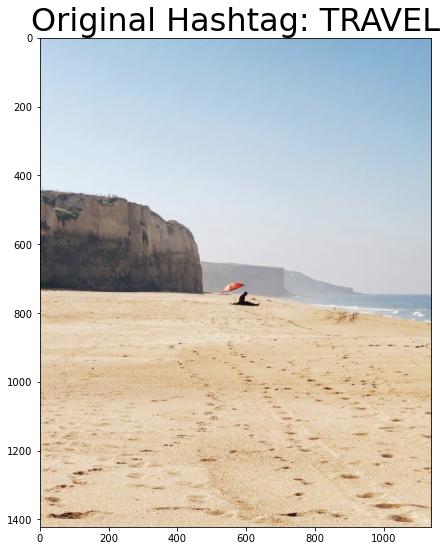

In [32]:
show_results('travel')

1/1 [==============================] - 0s 31ms/step
#nature, #art, #explorepage, #explore, #photooftheday, #animal, #illustration, #coffeetime, #drawing, #coffeegram


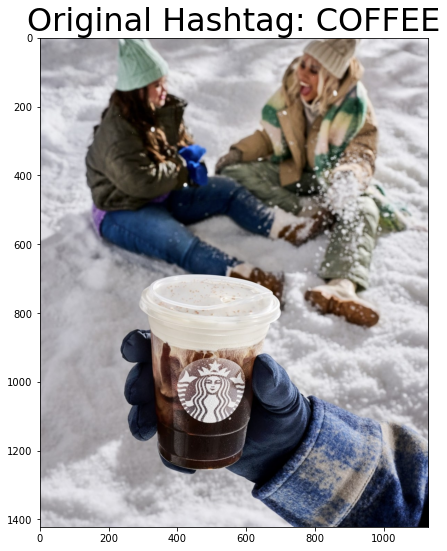

In [33]:
show_results('coffee')

1/1 [==============================] - 0s 30ms/step
#art, #selfie, #beautiful, #love, #photooftheday, #model, #goodmorning, #food, #makeup, #smile


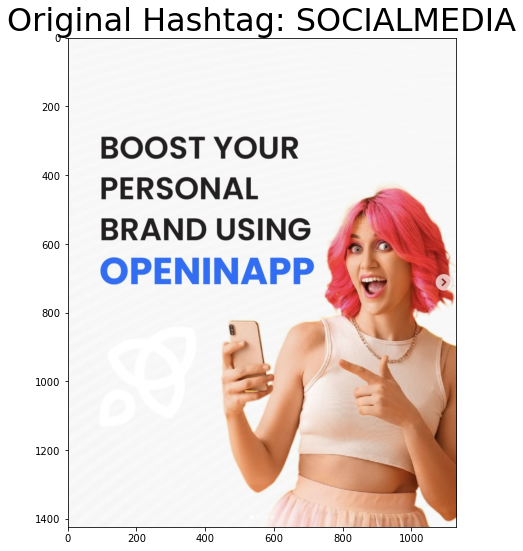

In [34]:
show_results('socialmedia')

### Conclusion
#### Given that this model has only been trained with data collected of about 80 posts from instagram,
#### the generated hashtags are fairly suitable with scope to do much better in the future.